# Meshing with FEniCSx API

This Jupyter Notebook delves into the fundamental aspects of meshing using the FEniCSx API. It serves as an interactive guide, focusing on the practical implementation of meshing for applications to sonic crystals. This first implementation is concerned with defining domains on which cylindrical sonic crystals can be researched.

## Overview

Meshing is a critical step in the numerical simulation of physical phenomena, where a geometric domain is discretized into smaller, manageable elements. The FEniCSx API offers robust tools for creating and manipulating these meshes, allowing for detailed and accurate simulations.

### Key Concepts

- **Layers Definition**: Understand how to define various layers in a mesh, each possessing unique properties suitable for specific simulation needs.
- **Adiabatic Absorbers**: Learn about integrating adiabatic absorbers in your mesh to effectively truncate the computational domain, minimizing reflections and edge effects.
- **Cylindrical Sonic Crystals**: Explore the creation and application of cylindrical sonic crystals within your mesh, a crucial aspect for studies in acoustic metamaterials.
- **Constant Wave Number Domains**: Discover how to configure free domains with a constant wave number, essential for simulations involving wave propagation.

## Objectives

1. Create and manipulate meshes using FEniCSx API.
2. Implement different layer properties in a mesh, understanding their physical implications.
3. Integrate specialized elements like adiabatic absorbers and sonic crystals into your simulations.
4. Apply the concepts learned to model complex physical systems accurately.

In [1]:
import numpy as np
from matplotlib import colormaps, colors
import matplotlib.pyplot as plt

from src.data.helmholtz.meshing import *

In [2]:
def plot_box(x: np.array, y: np.array, val: np.array) -> None:
    """Simple utility function for visualizing a value on a domain
    """
    val_max = np.max(np.abs(val))
    centered_cmap = colors.TwoSlopeNorm(vmin=-val_max, vmax=val_max, vcenter=0)
    ax = plt.imshow(val,
                    cmap=colormaps["seismic"],
                    norm=centered_cmap,
                    extent=(np.min(x), np.max(x), np.min(y), np.max(y)))
    plt.colorbar(ax)
    plt.show()
    plt.clf()

## Properties of the domain and physics

In [3]:
k = 1
rt = 1e-6

n_samples = 300  # samples per direction for plotting
x_plot, y_plot = np.meshgrid(
    np.linspace(-0.5, 10.5, n_samples),
    np.linspace(-0.5, 10.5, n_samples)
)

## Defining a Domain

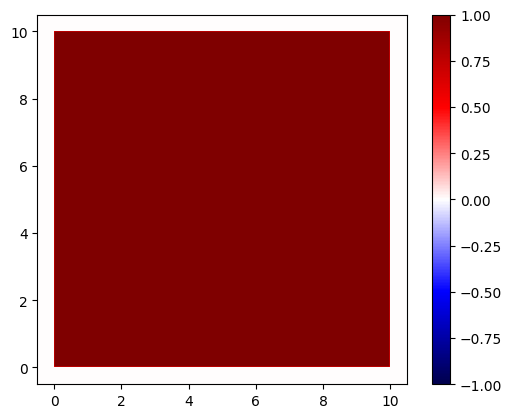

<Figure size 640x480 with 0 Axes>

In [12]:
# simple box with constant wave-number
box = BoxDomain("Example domain", 10, 10, {"k": ConstantProperty(k)})
k_out = box.eval("k", [x_plot, y_plot])
k_out_real = np.real(k_out)
plot_box(x_plot, y_plot, k_out_real)

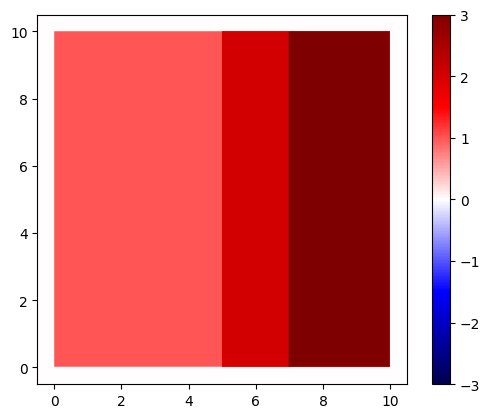

<Figure size 640x480 with 0 Axes>

In [13]:
# two boxes with different wave-numbers inside a third one
box1 = BoxDomain("box 1", 2, 10, {"k": ConstantProperty(k)})
box2 = BoxDomain("box 2", 3, 10, {"k": ConstantProperty(2 * k)})
box3 = BoxDomain("box 3", 5, 10, {"k": ConstantProperty(k)}, sub_domains=[box1, box2], direction=Direction.positive_x)

k_out = box3.eval("k", [x_plot, y_plot])
k_out_real = np.real(k_out)
plot_box(x_plot, y_plot, k_out_real)

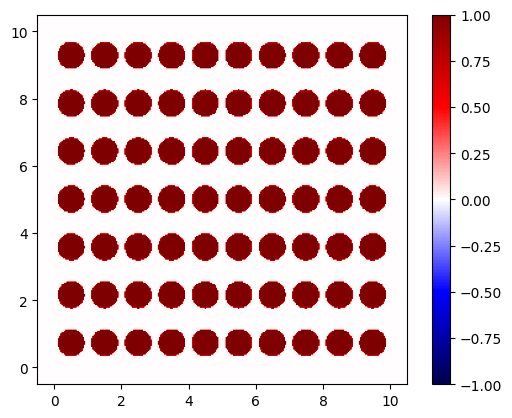

<Figure size 640x480 with 0 Axes>

In [14]:
# Sonic Crystals
crystals1 = BoxDomain("Crystals", 10, 10, {"k": CylindricalCrystalProperty(10, 10, 10, 7, 0.4, k)})
k_out = crystals1.eval("k", [x_plot, y_plot])
k_out_real = np.real(k_out)
plot_box(x_plot, y_plot, k_out_real)

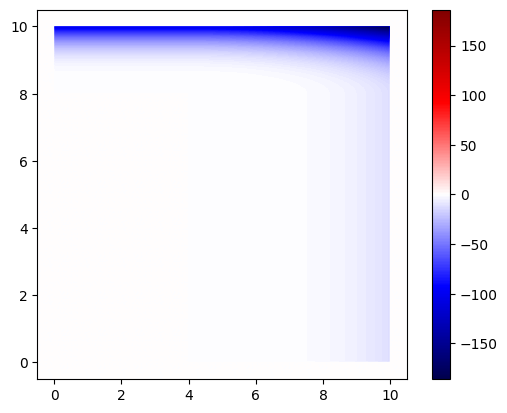

<Figure size 640x480 with 0 Axes>

In [15]:
# Adiabatic Absorber
abs1 = AdiabaticLayer(10, 10, 1.e-6, {0: [4, 10], 1: [2, 0]}, [("k", k)])
k_out = abs1.eval("k", [x_plot, y_plot])
k_out_real = np.real(k_out)
plot_box(x_plot, y_plot, k_out_real)

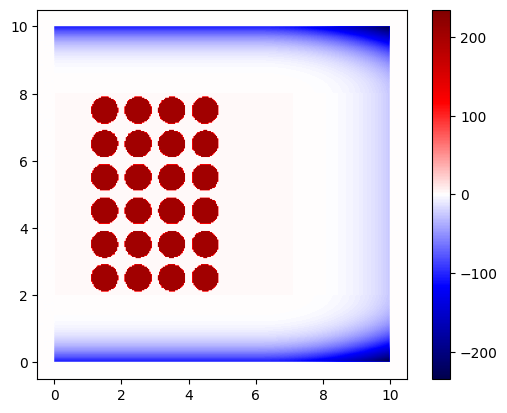

<Figure size 640x480 with 0 Axes>

In [20]:
# An entire domain 
free_space_l = BoxDomain("Free Space left", 1, 6, {"k": ConstantProperty(0)})
crystals = BoxDomain("Crystals", 4, 6,
                     {"k": CylindricalCrystalProperty(4, 6, 4, 6, 0.4, k * 200)})  # bumped up value for visualization
free_space_r = BoxDomain("Free Space right", 1, 6, {"k": ConstantProperty(0)})
absorber = AdiabaticLayer(4, 6, 1.0e-6, {0: [0, 4]}, [("k", k)])

inside = BoxDomain(
    "sim area",
    sub_domains=[free_space_l, crystals, free_space_r, absorber],
    direction=Direction.positive_x,
    properties={"k": ConstantProperty(k)}
)
top_absorber = AdiabaticLayer(10, 2, 1.e-6, {0: [6, 10], 1: [0, 2]}, [("k", k)])
bot_absorber = AdiabaticLayer(10, 2, 1.e-6, {0: [6, 10], 1: [2, 0]}, [("k", k)])

domain = BoxDomain(
    "total",
    sub_domains=[bot_absorber, inside, top_absorber],
    direction=Direction.positive_y,
    properties={"k": ConstantProperty(k)}
)
k_out = domain.eval("k", [x_plot, y_plot])
k_out_real = np.real(k_out)
plot_box(x_plot, y_plot, k_out_real)

## Meshing with properties

In [ ]:
import dolfinx
from dolfinx.fem import Function, functionspace
from mpi4py import MPI
import pyvista

In [ ]:
n_elem = 128

mesh = dolfinx.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([10, 10])],
    (n_elem, n_elem),
    dolfinx.mesh.CellType.triangle
)

V = functionspace(mesh, ("Lagrange", 1))
k = Function(V)
k.interpolate(domain.eval)

In [ ]:
pyvista_grid = dolfinx.plot.create_vtk_mesh(V)
k_values = k.compute_point_values().real
pyvista_grid.point_data["k"] = k_values

# Create a PyVista plotter and add the mesh
plotter = pyvista.Plotter()
plotter.add_mesh(pyvista_grid, scalars="u", show_edges=True)

# Show the plot
plotter.show()